In [1]:
# Import libraries
import mne
import json
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import zscore
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath("../Functions"))

# Import custom scripts
import import_data
import data_tools
import processing

# Enable interactive plots
%matplotlib qt

In [2]:
# Load list of files to import
files = [  
"sub-Ashley_ses-1_task-T1_run-001_eeg"
]

# Get unique subject IDs
subject_ids = [file.split('_')[0] for file in files]

# Preallocate eeg_ts, eeg_data, eeg_fs
eeg_ts =   [None] * len(files)
eeg_data = [None] * len(files)
raw_eeg =  [None] * len(files)

ch_names = ["Fz", "F4", "F8", "C3", "Cz", "C4", "T8", "P7", "P3", "P4", "P8", "PO7", "PO8", "O1", "Oz", "O2"]

for f, file in enumerate(files):
    for sub in subject_ids:
        if sub == file.split('_')[0]:
            [eeg_ts[f], eeg_data[f], eeg_fs] = import_data.read_xdf(f"..\\Data\\{file}.xdf", picks=ch_names)

            # Create MNE array
            info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties
            raw_eeg[f] = mne.io.RawArray(eeg_data[f], info = info)            

            # Set standard channel montage
            raw_eeg[f].set_montage('standard_1020')

Creating RawArray with float64 data, n_channels=16, n_times=8080
    Range : 0 ... 8079 =      0.000 ...    31.559 secs
Ready.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 1691 samples (6.605 s)



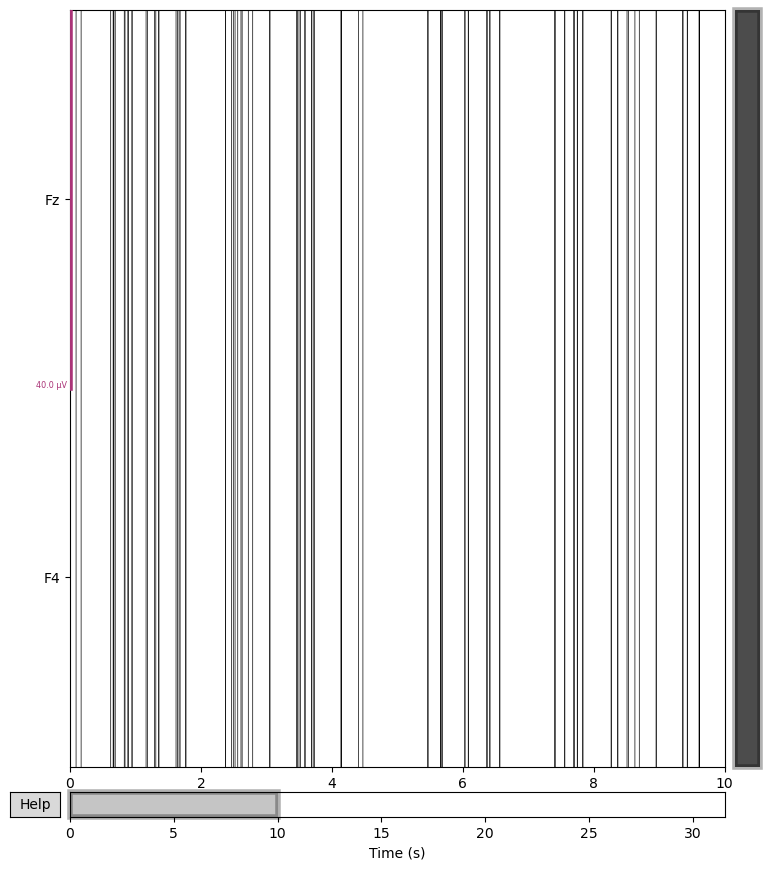

In [22]:
# Preallocate lists for filtered data
filt_raw = [None] * len(files)

# Loop through each file and corresponding raw EEG
for f, file in enumerate(files):
    raw = raw_eeg[f]
    filt_raw[f] = raw.copy().filter(l_freq=0.5, h_freq=8, picks=ch_names)

filt_raw[0].plot(picks = ['Fz', 'F4'])

## Compute Z-scores for raw time-series (before epoching)

In [4]:
epoch_length = 1280

filtered = filt_raw[0].get_data(picks = ['Fz', 'F4'])

z_scored_data = zscore(filtered, axis=1)

n_epochs = z_scored_data.shape[1] // epoch_length

z_scored_epochs = [z_scored_data[:, i*epoch_length : (i + 1)*epoch_length] for i in range(n_epochs)]

if z_scored_data.shape[1] % epoch_length != 0:
    z_scored_epochs.append(z_scored_data[:, n_epochs * epoch_length:])

In [16]:
def count_eye_blinks_v2(eeg_epochs, sfreq, channel_names, frontal_channels=['Fz', 'F4'], min_dist_ms=100):
    frontal_idxs = [i for i, ch in enumerate(channel_names) if ch in frontal_channels]
    if not frontal_idxs:
        raise ValueError("No frontal channels found in data.")

    blink_counts = []
    min_dist_samples = int(sfreq * (min_dist_ms / 1000))

    for epoch in eeg_epochs:
        # Average signal from frontal channels
        frontal_avg = np.mean(epoch[frontal_idxs, :], axis=0)

        # Find both positive and negative peaks above threshold
        pos_peaks, _ = signal.find_peaks(frontal_avg, height=2)
        neg_peaks, _ = signal.find_peaks(-frontal_avg, height=2)

        # Combine and sort peaks
        all_peaks = np.sort(np.concatenate((pos_peaks, neg_peaks)))

        # Apply minimum distance filtering
        filtered_peaks = []
        last_peak = -np.inf

        for peak in all_peaks:
            if peak - last_peak >= min_dist_samples:
                filtered_peaks.append(peak)
                last_peak = peak

        blink_counts.append(len(filtered_peaks))

    return blink_counts


In [ ]:
blink_count_z = []  # Final list of blink counts per epoch

for epoch in z_scored_epochs:
    result = count_eye_blinks_v2(
        eeg_epochs=[epoch],  # one epoch at a time
        sfreq=eeg_fs,
        channel_names=ch_names,
        frontal_channels=['Fz', 'F4'],
    )
    blink_count_z.extend(result)  # result is a list with 1 item per epoch

print(blink_count_z)

[0, 6, 4, 4, 5, 5, 5]


In [21]:
# Loop through all epochs
for i, epoch in enumerate(z_scored_epochs):
    plt.figure(figsize=(10, 4))
    
    # Plot only the first two channels
    for ch in range(2):
        plt.plot(epoch[ch], label=f"Channel {ch}")
    
    plt.title(f"Epoch {i + 1} - Channels 0 and 1")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()